In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt

ratings = pd.read_csv("new_movies.csv") 

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed',)).History will not be written to the database.


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or 

In [2]:
#Get the number of unique users and movies

num_users = ratings['userId2'].nunique()
num_movies = ratings['movieId2'].nunique()

In [3]:
#Set up the training, validation, and test sets

X = ratings[['userId2', 'movieId2','rating']].values
y = ratings['rating'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [4]:
X_train_train, X_val, y_train_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
# X_train_train.shape, X_val.shape, y_train_train.shape, y_val.shape

In [5]:
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

In [6]:
X_train_train_array = [X_train_train[:, 0], X_train_train[:, 1]]
X_val_array = [X_val[:, 0], X_val[:, 1]]

In [7]:
#Set up arrays for each number of dimensions and the RMSEs

num_factors_array = np.array((10,20,30,40,50,60,70,80,90,100))
rmse_array = np.zeros((num_factors_array.shape))

In [8]:
#Function to create tensorflow model for the movie recommender

def MovieRecommender(num_users, num_movies, num_factors):
    user_input = tf.keras.layers.Input(shape=(1,))
    users = tf.keras.layers.Embedding(num_users, num_factors)(user_input)
    users = tf.keras.layers.Reshape((num_factors,))(users)
    
    movie_input = tf.keras.layers.Input(shape=(1,))
    movies = tf.keras.layers.Embedding(num_movies, num_factors)(movie_input)
    movies = tf.keras.layers.Reshape((num_factors,))(movies)
    
    dot_product = tf.keras.layers.Dot(axes=1)([users, movies])
    model = tf.keras.models.Model(inputs=[user_input, movie_input], outputs=dot_product)
    model.compile(loss='mean_squared_error', optimizer = tf.keras.optimizers.Adam(lr=0.001), metrics=['mean_squared_error'])
    return model

In [10]:
#Iterate through each number of dimensions, create the model, and compute the validation RMSE

for idx,i in enumerate(num_factors_array):   
    model = MovieRecommender(num_users, num_movies, i)
    es = tf.keras.callbacks.EarlyStopping(monitor='loss', mode='min', min_delta=0.01, patience=2)
    history = model.fit(X_train_train_array, y_train_train, epochs=1000, batch_size=32, callbacks=[es],verbose=0)
    rmse = model.evaluate(X_val_array, y_val,verbose=0)
    rmse = rmse[1]
    print('Number of Dimensions: ', i, ' Validation RMSE: ', rmse)
    rmse_array[idx] = rmse

Number of Dimensions:  10  Validation RMSE:  0.61913705
Number of Dimensions:  20  Validation RMSE:  0.5331902
Number of Dimensions:  30  Validation RMSE:  0.55625486
Number of Dimensions:  40  Validation RMSE:  0.5932095
Number of Dimensions:  50  Validation RMSE:  0.6203899
Number of Dimensions:  60  Validation RMSE:  0.65357536
Number of Dimensions:  70  Validation RMSE:  0.6986598
Number of Dimensions:  80  Validation RMSE:  0.7615366
Number of Dimensions:  90  Validation RMSE:  0.77375275
Number of Dimensions:  100  Validation RMSE:  0.8523783


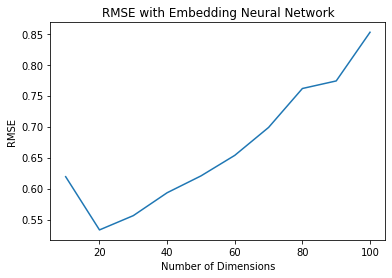

In [11]:
#Plot how RMSE changes with the number of dimensions

plt.plot(num_factors_array, rmse_array)
plt.title('RMSE with Embedding Neural Network')
plt.xlabel('Number of Dimensions')
plt.ylabel('RMSE')
plt.show()

In [12]:
#Find the optimal number of dimensions (minimize RMSE)

optimal_idx = np.argmin(rmse_array)
optimal_dimensions = num_factors_array[optimal_idx]

# for idx in range(1,num_factors_array.shape[0]):
#     if (rmse_array[idx-1] - rmse_array[idx]) < 0.001:
#         optimal_dimensions = num_factors_array[idx-1]
#         break

print('Optimal Number of Dimensions: ', optimal_dimensions)


#Build model with optimal number of dimensions and calculate RMSE on test set

model = MovieRecommender(num_users, num_movies, optimal_dimensions)
es = tf.keras.callbacks.EarlyStopping(monitor='loss', mode='min', min_delta=0.01, patience=2)
history = model.fit(X_train_array, y_train, epochs=1000, batch_size=32, callbacks=[es],verbose=0)
rmse = model.evaluate(X_test_array, y_test,verbose=0)
print('Test RMSE: ', rmse[1])

Optimal Number of Dimensions:  20
Test RMSE:  0.5044226


In [13]:
#Make predictions for test set

predictions = model.predict(X_test_array, verbose=0)

In [14]:
#Calculate average precision, recall, and F1 scores

X_test_df = pd.DataFrame(X_test)

X_predicted = pd.DataFrame(X_test)

X_predicted[2] = predictions

userID_list = X_test_df[0].unique()

recommendations_indices = np.zeros(shape = (len(userID_list),25))

for idx,i in enumerate(userID_list):
    pred_df = X_predicted[X_predicted[0]==i]
    top = pred_df.nlargest(25, 2)
    recommendations = top[1].values
    recommendations_indices[idx,:] = recommendations

precision_matrix = np.zeros(shape=(len(userID_list)))
recall_matrix = np.zeros(shape=(len(userID_list)))
f1_matrix = np.zeros(shape=(len(userID_list)))

for idx,i in enumerate(userID_list):
    ratings_df = X_test_df[X_test_df[0]==i]
    top_movies_rated = ratings_df[ratings_df[2]>=3.5]
    top_rated_indices = top_movies_rated[1].values
    
    tp = len(np.intersect1d(recommendations_indices[idx,:], top_rated_indices))
    fp = len(recommendations_indices)-tp
    fn = len(top_rated_indices)-tp

    precision = tp / (tp + fp + 1e-10)
    precision_matrix[idx] = precision
    recall = tp / (tp + fn + 1e-10)
    recall_matrix[idx] = recall
    f1 = 2.0 * (precision * recall) / (precision + recall + 1e-10)
    f1_matrix[idx] = f1


avg_precision = np.average(precision_matrix)
avg_recall = np.average(recall_matrix)
avg_f1 = np.average(f1_matrix)
print('Average Precision: ', avg_precision)
print('Average Recall: ', avg_recall)
print('Average F1 Score: ', avg_f1)

Average Precision:  0.014391319313542933
Average Recall:  0.6013909886388143
Average F1 Score:  0.028050117712374548
